# Problema de prediccion de ventas

## Planteamiento del problema y Objetivo:

El objetivo es construir un modelo de regresión simple para predecir las **ventas por producto de una tienda en particular**, que forma parte de una cadena de tiendas, y descubrir cuáles son los **principales factores que influencian dicha predicción**.

### Importando Librerías

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from scipy import stats

### Lectura de los datasets

In [131]:
data_train = pd.read_csv('../../data/Train_BigMart.csv')
data_test = pd.read_csv('../../data/Test_BigMart.csv')
# Identificando la data de train y de test, para posteriormente unión y separación
data_train['Set'] = 'train'
data_test['Set'] = 'test'

Combinando los dataset de *entrenamiento y test* para proceder a realizar la exploración, visualización, limpieza de datos, y posterior ingeniería de características y codificación de variables.

In [132]:
data = pd.concat([data_train, data_test], ignore_index=True, sort=False)
data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Set
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


## EDA

In [133]:
print('Variables:', list(data.columns))

Variables: ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales', 'Set']


###  Resumen de los datasets

In [134]:
print('Número de registros de train:', data_train.shape[0], '  -   Número de variables:', data_train.shape[1])
print('Número de registros de test:', data_test.shape[0], '  -   Número de variables:', data_test.shape[1])
print('Número de registros totales:', data.shape[0], '  -   Número de variables:', data.shape[1])

Número de registros de train: 8523   -   Número de variables: 13
Número de registros de test: 5681   -   Número de variables: 12
Número de registros totales: 14204   -   Número de variables: 13


Visión general de las variables en cada dataset:

In [135]:
print('Dataset de entrenamiento:\n')
data_train.info()
print('\nDataset de test:\n')
data_test.info()
print('\nDataset de total:\n')
data.info()
#data_train.info(), data_test.info(), data.info()

Dataset de entrenamiento:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Set                        8523 non-null   object 
dtypes: float64(4), int64(

En función del tipo de variables observado, las variables de tipo object corresponde a variables categóricas que deberán ser codificadas. También se observan algunos datos faltantes que deberán ser imputados.

Se tiene una columna más en los datasets de train y total, correspondiente al Target (Item_Outlet_Sales).

### Variables:

- Item_Identifier: nombre o identificador del producto 
- Item_Weight: peso del producto (en gramos)
- Item_Fat_Content: clasificación del producto en términos de grasas contenidas en él. 
- Item_Visibility: scoring de visibilidad del producto: medida que hace referencia al conocimiento del producto en el consumidor. ¿Qué tan fácil puede ser encontrado el producto? 
- Item_Type: tipo de producto 
- Item_MRP: máximum retailed price. Precio calculado por el fabricante que indica el precio más alto que se puede cobrar por el producto. 
- Outlet_Identifier: identificador de la tienda 
- Outlet_Establishment_Year: año de lanzamiento de la tienda 
- Outlet_Size: tamaño de la tienda 
- Outlet_Location_Type: clasificación de las tiendas según ubicación 
- Outlet_Type: tipo de tienda 
- Item_Outlet_Sales: ventas del producto en cada observacion

## Planteamiento de Hipótesis:
Respecto a las variables que se disponen en el dataset y de acuerdo al objetivo propuesto, se plantean algunas hipótesis:
- El peso del producto no debería influir en los niveles de venta de la tienda.
- El contenido de grasas de los productos puede ser significativo pra el nivel de venta (Los productos con mayor contenido de grasa quiezás se compran menos).
- La visibilidad de un producto incide en el nivel de venta de la tienda (generalmente los productos más costosos se exhiben en sitios de fácil visualización para el cliente).
- El tipo de producto puede influir en el nivel de ventas (existe productos de mayor y menor rotación, pero también de mayor y menor precio).
- El precio de un producto es un factor que está directamente asociado con el nivel de ventas.
- El año de lanzamiento de la tienda, da información del tiempo de vida que puede tener la tienda; esto podría influir en el nivel del conocimiento que tiene el cliente de la existencia de la tienda, y por ende de su nivel de ventas.
- A mayor tamaño de la tienda, mayor nivel de ventas. Las personas le suelen gustar los lugares amplios para ir de compras.
- La ubicación de la tienda es un factor preponderante en el acceso al cliente y por ende en el nivel de ventas.

### Análisis univariado

### Resumen estadístico de variables cuantitativas o numéricas:
Obtener más información de los datos a través de el comportamiento y distribución de los mismos.

In [136]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


No se observan valores llamativos en los descriptores estadísticos de cada distribución.

Refleja valores perdidos en la variable "Item_Weight" (la diferencia de valores en la variable "Item_Outlet_Sales" corresponde a los valores de TARGET en el train dataset)

**La variable "Outlet_Establishment_Year" será tomada como vida del establecimiento en años, la cual puede dar una información más valiosa.**

### Visualizando las variables numéricas:

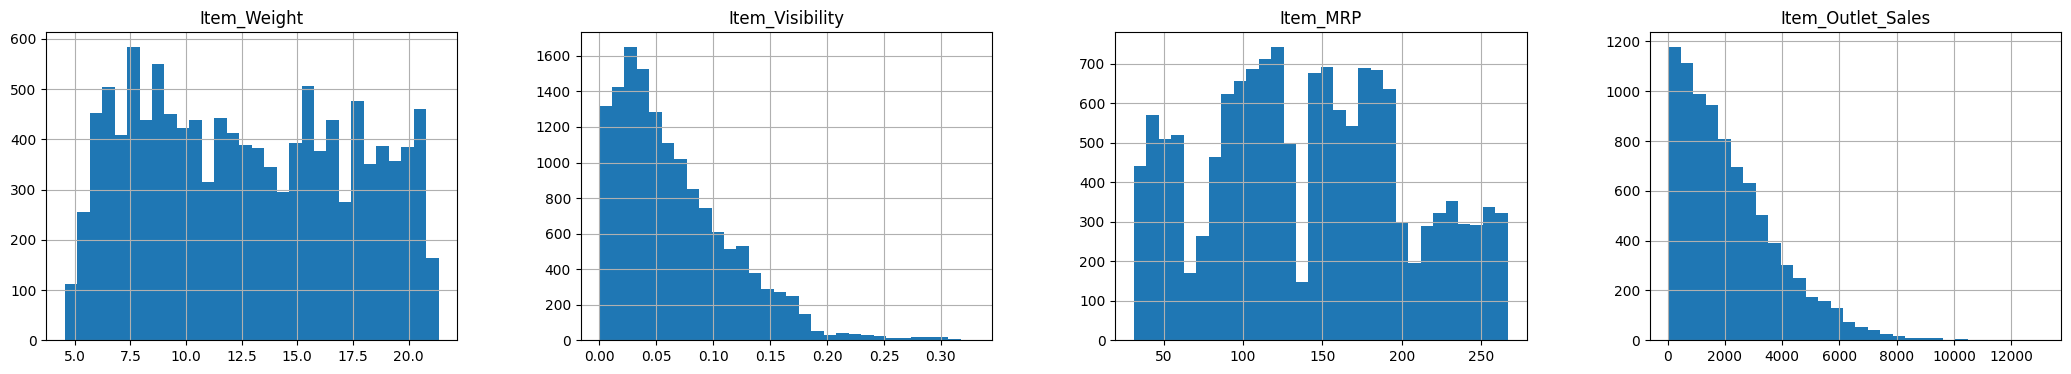

In [137]:
# Visualización de las caraterísticas númericas de entrada
data.hist(column=['Item_Weight', 'Item_Visibility',	'Item_MRP', 'Item_Outlet_Sales'], figsize=(26,4), bins=30, layout=(1,4))
plt.show()

TARGET: Las ventas de la tiendas (Item_Outlet_Sales) presentan una distribución con sesgo positivo, es decir, sus valores se concentran más en los niveles de ventas inferiores.

Los pesos de los productos (Item_Weight) presentan una distribución clara, no se encuentra concentración de frecuencias en valores específicos.

La visibilidad de los productos (Item_Visibility) también presenta una distribución sesgada positivamente, se observa mayor concentración en valores inferiores.

El precio máximo por producto (Item_MRP) presenta una distribución multimodal, de aproximadamente 4 niveles de precios distintos.

*Las variables sesgadas se les tratará para eliminar dicho sesgo.*

- Por ahora, se realizará el cálculo de años de vida de la tienda en base al año de establecimiento y el año actual (se asume que es data del actual año 2019):

#### FEATURES ENGINEERING: para los años del establecimiento

In [138]:
data['Outlet_Establishment_Year'] = 2020 - data['Outlet_Establishment_Year']

## Definiendo las variables categóricas

### Resumen estadístico de variables categóricas:

In [139]:
data.describe(include = ['object', 'category'])

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Set
count,14204,14204,14204,14204,10188,14204,14204,14204
unique,1559,5,16,10,3,3,4,2
top,FDH04,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1,train
freq,10,8485,2013,1559,4655,5583,9294,8523


- Item_Identifier posee muchos valores únicos que no se podrán analizar de esta manera tan dispersa, se puede tratar de agrupar según alguna patrón de la codificación.
- Item_Type también posee un número de características que se podrían agrupar para evitar trabajar con 16 valores; de ser conveniente para la predicción.
- Las demás variables tienen número de categorías finitas convenientes para el análisis.
- Se tienen valores faltantes en la variable Outlet_Size que habrá que trabajar.

Seguido se hace una exploración más detallada:

### Conociendo las variables categóricas:

In [140]:
categoricals = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
for cat in categoricals:
    print(cat, ':', set(data[cat]))

Item_Fat_Content : {'Regular', 'Low Fat', 'low fat', 'LF', 'reg'}
Item_Type : {'Health and Hygiene', 'Dairy', 'Snack Foods', 'Starchy Foods', 'Soft Drinks', 'Meat', 'Household', 'Baking Goods', 'Frozen Foods', 'Canned', 'Fruits and Vegetables', 'Breakfast', 'Others', 'Breads', 'Hard Drinks', 'Seafood'}
Outlet_Identifier : {'OUT018', 'OUT046', 'OUT045', 'OUT013', 'OUT049', 'OUT035', 'OUT017', 'OUT019', 'OUT010', 'OUT027'}
Outlet_Size : {'Small', nan, 'Medium', 'High'}
Outlet_Location_Type : {'Tier 3', 'Tier 1', 'Tier 2'}
Outlet_Type : {'Supermarket Type1', 'Supermarket Type3', 'Supermarket Type2', 'Grocery Store'}


Del análisis se observa:
- Para "Item_Fat_Content" diferentes etiquetas para la misma categoría. **Acción**: unificar etiquetas.
- Se considera reagrupar algunas categorías de "Item_Type".

#### LIMPIEZA: Unificando etiquetas para 'Item_Fat_Content'

In [141]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'low fat':  'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

Verificamos la unificación de etiquetas:

In [142]:
set(data['Item_Fat_Content'])

{'Low Fat', 'Regular'}

### Miramos el comportamiento de las frecuencias de las variables categóricas:

In [143]:
for aux in ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']:
    print('\n', aux, ':\n', data[aux].value_counts())


 Item_Fat_Content :
 Item_Fat_Content
Low Fat    9185
Regular    5019
Name: count, dtype: int64

 Item_Type :
 Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: count, dtype: int64

 Outlet_Identifier :
 Outlet_Identifier
OUT027    1559
OUT013    1553
OUT035    1550
OUT049    1550
OUT046    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: count, dtype: int64

 Outlet_Size :
 Outlet_Size
Medium    4655
Small     3980
High      1553
Name: count, dtype: int64

 Outlet_Location_Type :
 Outlet_Location_Type
Tier 3  

### Visualizando la distribucón de frecuencias de las variables categóricas:

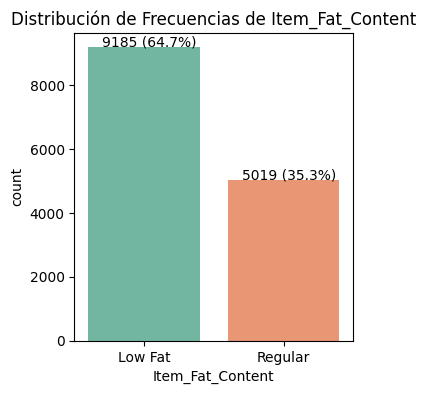

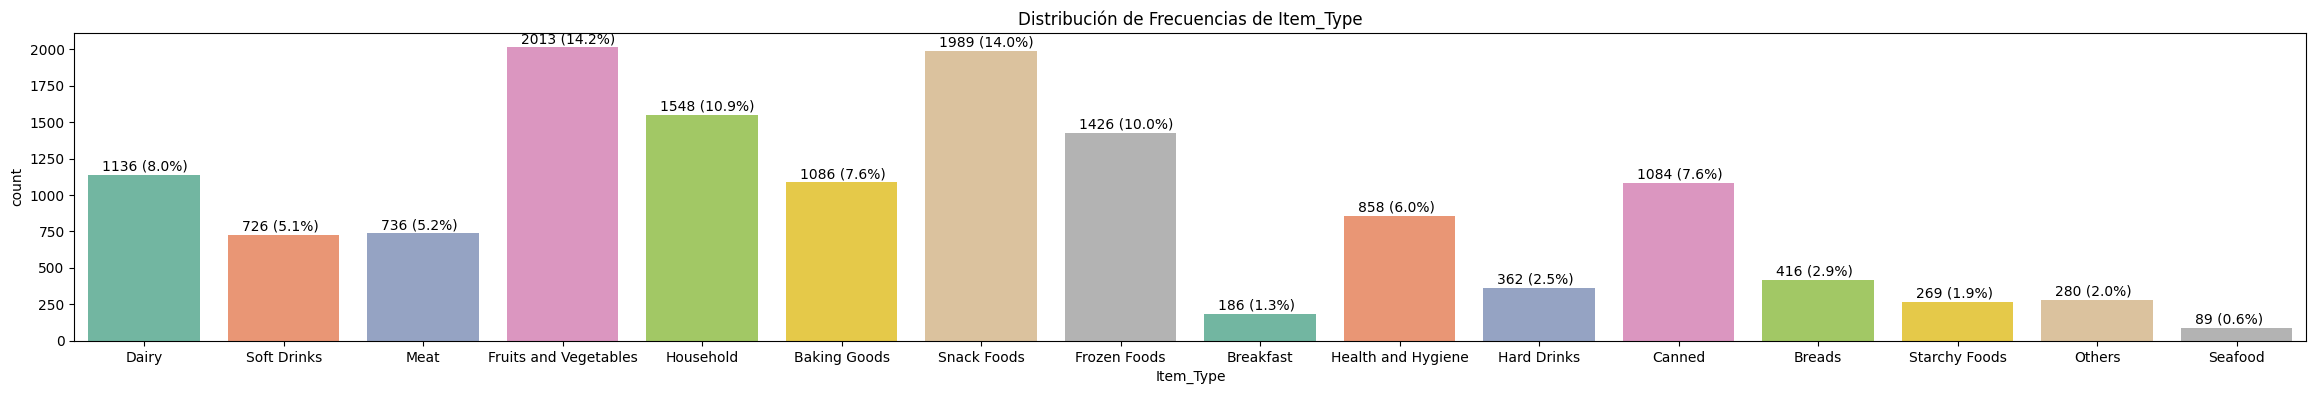

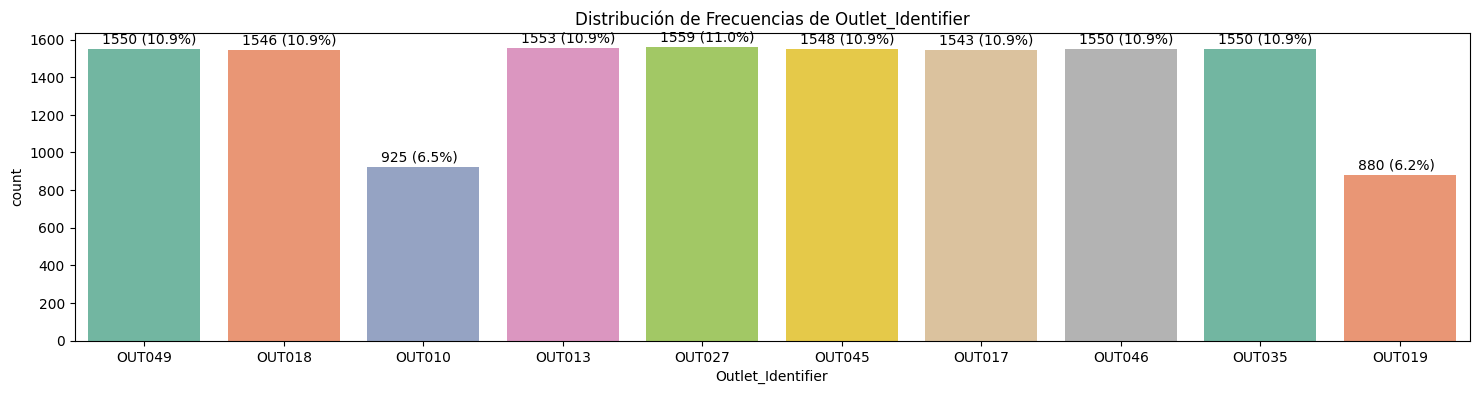

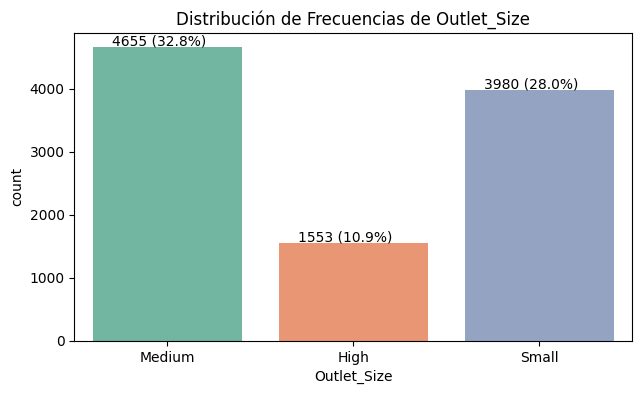

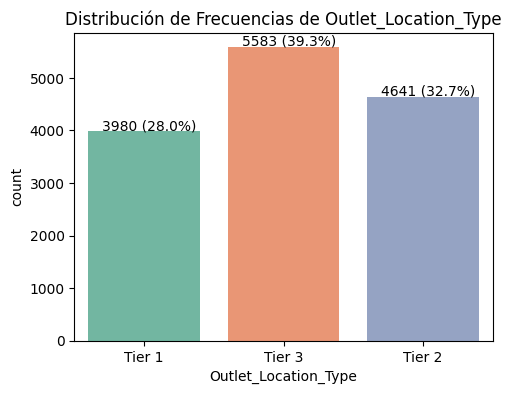

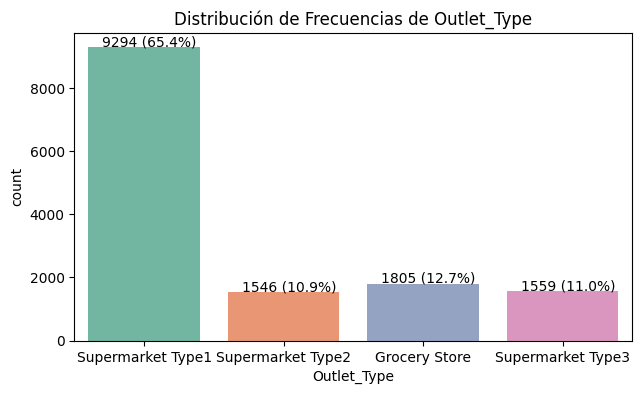

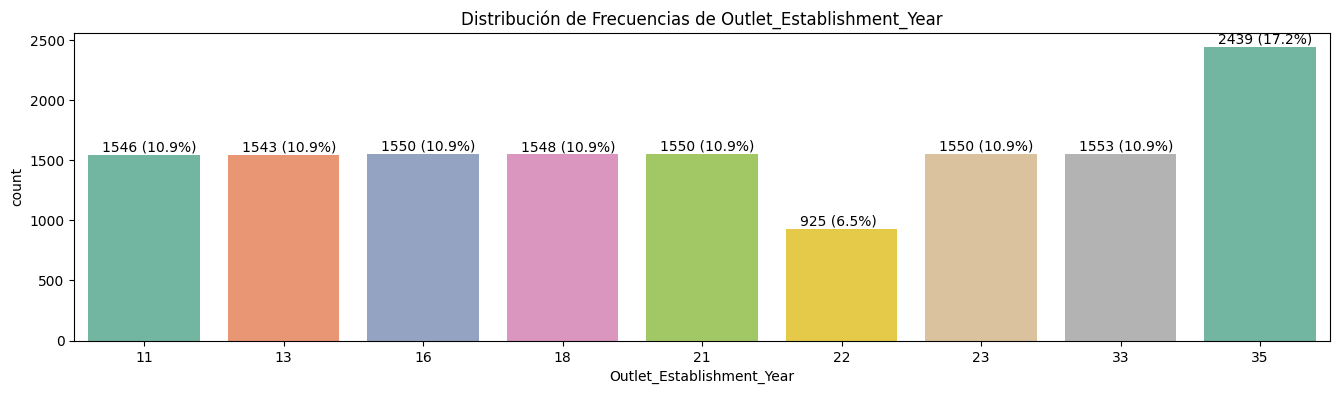

In [144]:
for var_cat in ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Establishment_Year']:
    ancho_bar = len(data[var_cat].unique())
    plt.figure(figsize=(ancho_bar*1.8,4))
    values = data[var_cat].dropna().sum()
    ax = sns.countplot(x= var_cat, data=data, palette='Set2')
    for p in ax.patches:
        ax.annotate('{:.0f} ({:.1f}%)'.format(p.get_height(), p.get_height()/len(data)*100), (p.get_x()+0.1, p.get_height()+30))
    plt.title('Distribución de Frecuencias de ' + var_cat)
    plt.show()

- El mayor porcentaje de producto corresponde a los bajos en grasas (aprox 65%)
- Los productos con mayor registros son los vegetales-frutas y los snacks, seguidos de los productos del hogar, enlatados, lácteos, congelados y horneados. 
- Las tiendas con menores registros son la OUT10 y OUT19, el resto de las tiendas tienen un número de registros similar.
- Se tienen mayores registros en la tiendas pequeñas y medianas.
- El mayor número de registros de ventas lo presentan las tiendas con locación Tier 3 y las tiendas de tipo Supermarket Type1.

#### Porcentaje de valores perdidos

In [145]:
print('El porcentaje de valores perdidos de las variables: \n')
for var in data.columns:
    num_nan = data[var].isnull().sum()
    print('{}: \t\t{} ({:,.2f}%)'.format(var, num_nan, num_nan*100/len(data)))

El porcentaje de valores perdidos de las variables: 

Item_Identifier: 		0 (0.00%)
Item_Weight: 		2439 (17.17%)
Item_Fat_Content: 		0 (0.00%)
Item_Visibility: 		0 (0.00%)
Item_Type: 		0 (0.00%)
Item_MRP: 		0 (0.00%)
Outlet_Identifier: 		0 (0.00%)
Outlet_Establishment_Year: 		0 (0.00%)
Outlet_Size: 		4016 (28.27%)
Outlet_Location_Type: 		0 (0.00%)
Outlet_Type: 		0 (0.00%)
Item_Outlet_Sales: 		5681 (40.00%)
Set: 		0 (0.00%)


Se tiene 17,17% de valores perdidos en la variable de pesos del producto, lo cual se puede solucionar asignando el peso de un producto similar o desde otro registro del mismo producto. De similar manera se puede realizar con los valores faltantes (28,27%) de la variable Tamaño del outlet.

Parte del dataset con valores perdidos en la variable 'Item_Weight':

In [146]:
data[data['Item_Weight'].isnull()].sort_values('Item_Identifier').head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Set
12435,DRA12,NaN,Low Fat,0.040748,Soft Drinks,140.0154,OUT027,35,Medium,Tier 3,Supermarket Type3,NaN,test
4416,DRA24,NaN,Regular,0.039735,Soft Drinks,165.7868,OUT027,35,Medium,Tier 3,Supermarket Type3,4913.6040,train
2879,DRA24,NaN,Regular,0.069909,Soft Drinks,163.2868,OUT019,35,Small,Tier 1,Grocery Store,491.3604,train
6057,DRA59,NaN,Regular,0.127308,Soft Drinks,186.6924,OUT027,35,Medium,Tier 3,Supermarket Type3,7033.5112,train
6179,DRA59,NaN,Regular,0.223985,Soft Drinks,186.2924,OUT019,35,Small,Tier 1,Grocery Store,555.2772,train


In [147]:
print(list(data[data['Item_Weight'].isnull()]['Outlet_Identifier'].unique()))

['OUT027', 'OUT019']


Los valores faltantes de pesos de los productos corresponden a las tiendas cuyo código son 'OUT027' y 'OUT019'

In [148]:
print(len(list(data[data['Item_Weight'].isnull()]['Item_Identifier'].unique())))

1559


Se tienen 1559 productos de los 2439 registros con valores perdidos en la variable 'Item_Weight'

Ahora se procede a rellenar los faltantes en los registros de pesos, basado en el valor modal del peso del producto. (Imputación de casos similares)

#### LIMPIEZA: de faltantes en el peso de los productos

In [149]:
productos = list(data[data['Item_Weight'].isnull()]['Item_Identifier'].unique())
for producto in productos:
    moda = (data[data['Item_Identifier'] == producto][['Item_Weight']]).mode().iloc[0,0]
    data.loc[data['Item_Identifier'] == producto, 'Item_Weight'] = moda

Se verifica que no existan valores nulos para la variable peso del producto.

In [150]:
print('El porcentaje de valores perdidos de la variable "Item_Weight" es de:', data['Item_Weight'].isnull().sum()/len(data)*100)

El porcentaje de valores perdidos de la variable "Item_Weight" es de: 0.0


Se procede a revisar los faltantes de la variable tamaño de la tienda.

In [151]:
data[data['Outlet_Size'].isnull()].sort_values('Item_Identifier').tail(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Set
5271,NCZ41,19.85,Low Fat,0.064552,Health and Hygiene,125.2704,OUT045,18,NaN,Tier 2,Supermarket Type1,2127.8968,train
411,NCZ42,10.50,Low Fat,0.000000,Household,238.3248,OUT010,22,NaN,Tier 3,Grocery Store,711.0744,train
9642,NCZ42,10.50,Low Fat,0.011311,Household,238.7248,OUT045,18,NaN,Tier 2,Supermarket Type1,NaN,test
1115,NCZ42,10.50,Low Fat,0.011352,Household,236.5248,OUT017,13,NaN,Tier 2,Supermarket Type1,4029.4216,train
4924,NCZ53,9.60,Low Fat,0.040970,Health and Hygiene,188.7214,OUT010,22,NaN,Tier 3,Grocery Store,376.8428,train
11398,NCZ53,9.60,Low Fat,0.024527,Health and Hygiene,188.5214,OUT045,18,NaN,Tier 2,Supermarket Type1,NaN,test
10841,NCZ53,9.60,Low Fat,0.024616,Health and Hygiene,190.0214,OUT017,13,NaN,Tier 2,Supermarket Type1,NaN,test
214,NCZ54,14.65,Low Fat,0.000000,Household,161.5552,OUT010,22,NaN,Tier 3,Grocery Store,324.9104,train
1969,NCZ54,14.65,Low Fat,0.083528,Household,162.4552,OUT045,18,NaN,Tier 2,Supermarket Type1,2274.3728,train
13223,NCZ54,14.65,Low Fat,0.083831,Household,161.4552,OUT017,13,NaN,Tier 2,Supermarket Type1,NaN,test


In [152]:
print(list(data[data['Outlet_Size'].isnull()]['Outlet_Identifier'].unique()))

['OUT010', 'OUT045', 'OUT017']


Los valores faltantes de tamaño de la tienda corresponden a las tiendas cuyo código son 'OUT010', 'OUT045' y 'OUT017'

Se procede primero a verificar qué valores de tamaño registran estas tiendas.

In [153]:
outlets = list(data[data['Outlet_Size'].isnull()]['Outlet_Identifier'].unique())

In [154]:
categoria = data[data['Outlet_Identifier'] == 'OUT010']['Outlet_Size'].unique()
print('OUT010', categoria)

categoria = data[data['Outlet_Identifier'] == 'OUT045']['Outlet_Size'].unique()
print('OUT045', categoria)

categoria = data[data['Outlet_Identifier'] == 'OUT017']['Outlet_Size'].unique()
print('OUT017', categoria)

OUT010 [nan]
OUT045 [nan]
OUT017 [nan]


Se observa que estas 3 tiendas no tienen registros del tamaño de su tienda. Para dar solución a esto se buscará algún tipo de asociación de otra variable con el tamaño, para realizar la estimación de la categoría.

### Análisis Bi-variado:
Variables Categóricas vs Categóricas:

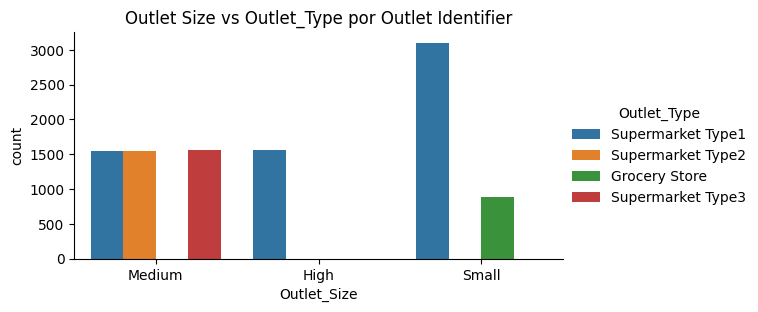

In [155]:
sns.catplot(x="Outlet_Size", hue='Outlet_Type', data=data, kind="count", height=3, aspect=2)
plt.title('Outlet Size vs Outlet_Type por Outlet Identifier')
plt.show()

- La mayoría de los "Supermarket Type 1" son de tamaño "Small".
- Las tiendas "Grocery Store" son de tamaño "Small".
- Las tiendas "Supermarket Type 2" y "Supermarket Type 3" son de tamaño "Medium".

- Outlet_Size vs Outlet_Type

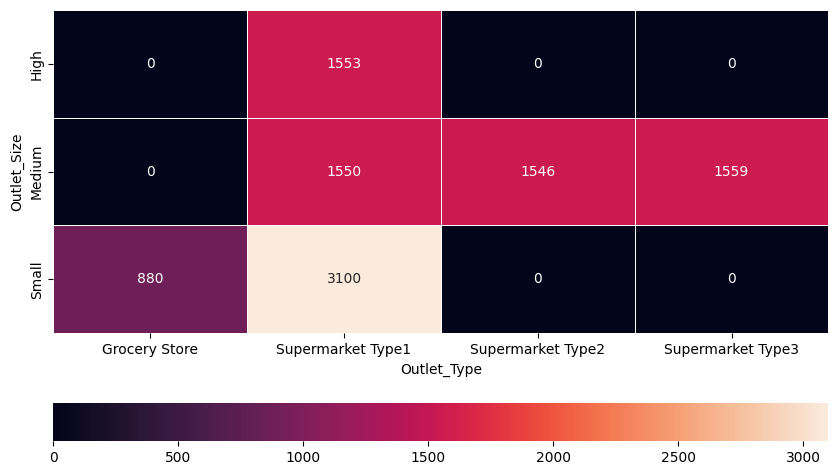

In [156]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.crosstab(data['Outlet_Size'], data['Outlet_Type'], margins=False, normalize=False), annot=True, square=False, fmt='', cbar_kws={"orientation": "horizontal"}, linewidths=0.5)
plt.show()

Se observa que no existe una relación entre el tipo de tienda y el tamaño de la misma. 
- Item_Type vs Outlet_Type

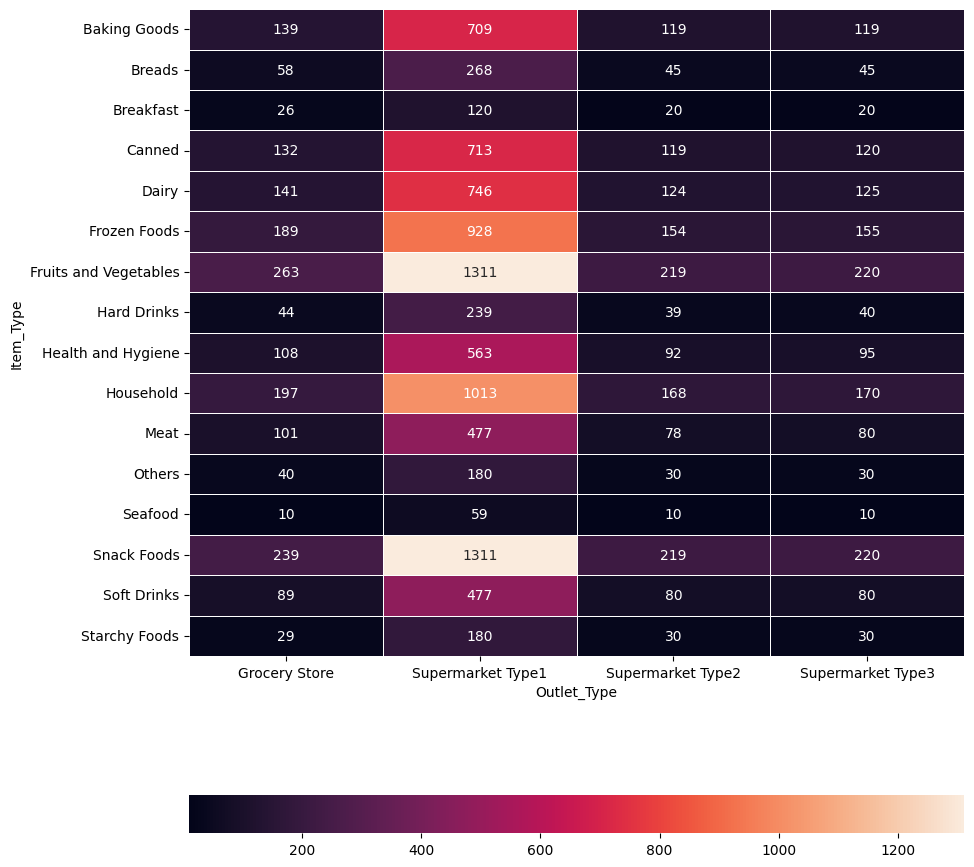

In [157]:
plt.figure(figsize=(10,12))
sns.heatmap(pd.crosstab(data['Item_Type'], data['Outlet_Type'], normalize=False), annot=True, square=False, fmt='', cbar_kws={"orientation": "horizontal"}, linewidths=0.5)
plt.show()

El Supermarket Type 2 y 3 presentan distribución similar respecto de los tipos de productos, al igual que en el tamaño de la tienda.
Vemos:
- Outlet_Location_Type vs Outlet_Type

In [158]:
import statsmodels.api as sm
tab = pd.crosstab(data['Outlet_Location_Type'], data['Outlet_Type'], margins=False, normalize=False)
plt.figure(figsize=(10,6))
sns.heatmap(tab, annot=True, square=False, fmt='', cbar_kws={"orientation": "horizontal"}, linewidths=0.5)
plt.show()

ModuleNotFoundError: No module named 'statsmodels'

- La mayor cantidad de registros son de la tienda "Supermarket Type 1" y de tamaño "Small"; en primer lugar de la ubicación "Tier 2" y en segundo de  la ubicación "Tier 1".

Veamos el tamaño de la tienda con respecto al nivel de ventas.

### Análisis Bi-variado:
Variables Categóricas vs Continuas:
- Veamos por un momento el tipo de tienda respecto a las ventas:

In [ ]:
plt.figure(figsize=(10,4))
sns.violinplot(x=data['Outlet_Type'], y=data["Item_Outlet_Sales"])
plt.show()

# H0: las medias son significativamente iguales entre los grupos (Se utiliza el test de Kruskal-Wallis por tratarse de una variable que no tiene una distribución normal)
print('\n', stats.kruskal(list(data.dropna().loc[data['Outlet_Type']== 'Supermarket Type1', 'Item_Outlet_Sales']), 
            list(data.dropna().loc[data['Outlet_Type']== 'Supermarket Type2', 'Item_Outlet_Sales']),
            list(data.dropna().loc[data['Outlet_Type']== 'Supermarket Type3', 'Item_Outlet_Sales']),
             list(data.dropna().loc[data['Outlet_Type']== 'Grocery Store', 'Item_Outlet_Sales'])))

- Se evidencia diferencias significativas en los niveles de ventas por tipo de tienda.
- La distribución de frecuencia de las variables estudiadas arriba son similares para los tipos de tiendas "Supermarket Type 2" y "Supermarket Type 3"; sin embargo no lo es así el comportamiento de las ventas. Se dejarán estas categorias separadas como están originalmente.

In [ ]:
sns.boxplot(x="Outlet_Size", y="Item_Outlet_Sales", data=data)
plt.show()

med=data.dropna().loc[data['Outlet_Size']=='Medium', 'Item_Outlet_Sales']
hig=data.dropna().loc[data['Outlet_Size']=='High', 'Item_Outlet_Sales']
sma=data.dropna().loc[data['Outlet_Size']=='Small', 'Item_Outlet_Sales']

sns.distplot(sma, kde=True, hist=False, label='Small'), sns.distplot(med, kde=True, hist=False, label='Medium'), sns.distplot(hig, kde=True, hist=False, label='High')
plt.show()

# Cálculo de promedios de ventas de cada tamaño de tienda
print('\nVentas promedios (Small):', sma.mean())
print('Ventas promedios (Medium):', med.mean())
print('Ventas promedios (High):', hig.mean())

print('\n', stats.kruskal(list(med), list(hig), list(sma)))  # H0: las medias son significativamente iguales entre los grupos

Mediante la prueba de Kruskal-Wallis se evidencia diferencias significativas en los niveles de venta para los distintos tamaños de tiendas.

Se somete a prueba las diferencias estadísticas entre el tamaño de tienda Small y High, para descartar similitud en sus ventas:

In [ ]:
stats.mannwhitneyu(list(hig), list(med))  # H0: las medias son significativamente iguales para ambos grupos

Se evidencia diferencias significativas entre las ventas promedios de ambos tamaños de tiendas (Medium y High).

Seguidamente se visualiza el comportamiento de las ventas de las tiendas que presentan VALORES PERDIDOS en el tamaño de tienda (Outlet_Size):

In [ ]:
data_aux = data[data['Outlet_Size'].isnull()]
plt.figure(figsize=(10,4))
sns.boxplot(x="Outlet_Identifier", y="Item_Outlet_Sales", data=data_aux)
plt.show()

Los valores de ventas en la tienda OUT10 son muy pequeños en comparación a las tiendas OUT17 y OUT45.

Graficando los diagramas box-plot de los niveles de ventas de las tiendas según tamaño (Oulet_Size) vs tipo de tienda (Outlet_Type):

In [ ]:
plt.figure(figsize=(15,4))
sns.boxplot(x="Outlet_Identifier", y="Item_Outlet_Sales", hue='Outlet_Size', data=data)
plt.show()

No se muestra algún patrón que se deba destacar.

Graficando diagramas box-plot de los niveles de ventas de las tiendas según el tipo de tienda (Outlet_Type):

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x="Outlet_Identifier", y="Item_Outlet_Sales", hue='Outlet_Type', data=data)
plt.show()

Se observa que la tienda OUT10 tiene un comportamiento similar en el nivel de ventas, que las tiendas OUT17 y OUT45 tienen coportamientos similares en sus ventas a las tiendas OUT13 y OUT46 respectivamente.

Se decide asignar a todos los valores perdidos del tamaño de las tiendas, la categoria "Small".

Tomando en consideración lo siguiente:
- El OUT10 es una tienda de tipo "Grocery Store" (lo que implica ser una tienda pequeña) y además tiene unas ventas similares al OUT19.
- El OUT17 es una tienda de tipo "Supermarket Type 1" (la mayoría de las tiendas "Supermarket Type 1" son de tamaño "Small").
- El OUT45 es una tienda de tipo "Supermarket Type 1" (la mayoría de las tiendas "Supermarket Type 1" son de tamaño "Small").

#### LIMPIEZA: de faltantes en el tamaño de las tiendas

In [ ]:
#data.loc[data['Outlet_Identifier'] == 'OUT10', 'Outlet_Size'] =  'Small'
#data.loc[data['Outlet_Identifier'] == 'OUT17', 'Outlet_Size'] =  'Small'
#data.loc[data['Outlet_Identifier'] == 'OUT45', 'Outlet_Size'] =  'Small'

In [ ]:
for outlet in outlets:
    data.loc[data['Outlet_Identifier'] == outlet, 'Outlet_Size'] =  'Small'

Se verifica que no existan valores nulos para la variable peso del producto.

In [ ]:
print('El porcentaje de valores perdidos de la variable "Outlet_Size" es de:', data['Outlet_Size'].isnull().sum()/len(data)*100)

Verificamos de nuevo los valores perdidos:

In [ ]:
print('El porcentaje de valores perdidos de las variables: \n')
for var in data.columns:
    print('{} \t\t {:,.2f}%:'.format(var, data[var].isnull().sum()/len(data)*100))

El 40% de valores perdidos que se observa arriba, corresponde a los datos de test que no contiene esta variale (por ser la variable respuesta que queremos obtener).

Verificando de nuevo los valores de la variables categóricas:

In [ ]:
print(aux, ':', set(data['Item_Fat_Content']))
print(aux, ':', set(data['Item_Type']))
print(aux, ':', set(data['Outlet_Identifier']))
print(aux, ':', set(data['Outlet_Size']))
print(aux, ':', set(data['Outlet_Location_Type']))
print(aux, ':', set(data['Outlet_Type']))

Ya se cuenta con un dataset un poco más limpio. Falta verificar las variables numéricas y recodificar las categorias de la variable "Item_Type"; para esta recodificación prodecemos a realizar primero una pruebas de significancia estadísticas. Pero antes, vemos algunos otros comportamientos bivariados:

In [ ]:
for var in ['Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Establishment_Year']:
    plt.figure(figsize=(len(data[var].unique())*2,4))
    sns.violinplot(x=var, y="Item_Outlet_Sales", data=data)
    plt.show()

Los valores de ventas de las diferentes categorias no tienen distribución normal. Se utilizará el test de Kruskal-Wallis (técnica no paramétrica) para determinar relación significativa entre las distintas variables y los niveles de ventas de la tiendas (TARGET).

In [ ]:
# H0: las medias son significativamente iguales entre los grupos
print('Test de Kruskal-Wallis para Item_Fat_Content vs Item_Outlet_Sales:\n\t', stats.kruskal(list(data.dropna().loc[data['Item_Fat_Content'] == 'Low Fat', 'Item_Outlet_Sales']), 
                                                                                         list(data.dropna().loc[data['Item_Fat_Content'] == 'Regular', 'Item_Outlet_Sales'])))

# H0: las medias son significativamente iguales entre los grupos
print('Test de Kruskal-Wallis para Item_Fat_Content vs Item_Outlet_Sales:\n\t', stats.kruskal(list(data.dropna().loc[data['Outlet_Location_Type'] == 'Tier 1', 'Item_Outlet_Sales']), 
                                                                                         list(data.dropna().loc[data['Outlet_Location_Type'] == 'Tier 2', 'Item_Outlet_Sales']), 
                                                                                         list(data.dropna().loc[data['Outlet_Location_Type'] == 'Tier 3', 'Item_Outlet_Sales'])))

En los graficos de violin se puede visualizar que el contenido de grasa en los productos no presenta influencia sobre el nivel de ventas y que las otras variables categóricas analizadas si tienen influencia sobre la variable TARGET; esto es corroborado por los test de Kruskal-Wallis realizados.

Respecto de la variable contenido de grasa de los productos, dicha conclusión arriba hecha no se corresponde con lo que se espera; lo que sugiere revisar más a fondo el registro de estas categorias. Para ello, realicemos una vista general de los datos:

In [ ]:
data[data['Item_Fat_Content'] == 'Low Fat'].head()

En la 3ra linea se encuentra una inconsistencia; no tiene sentido clasificar como "Low Fat" un producto del hogar. Veamos esto en un gráfico agrupado:

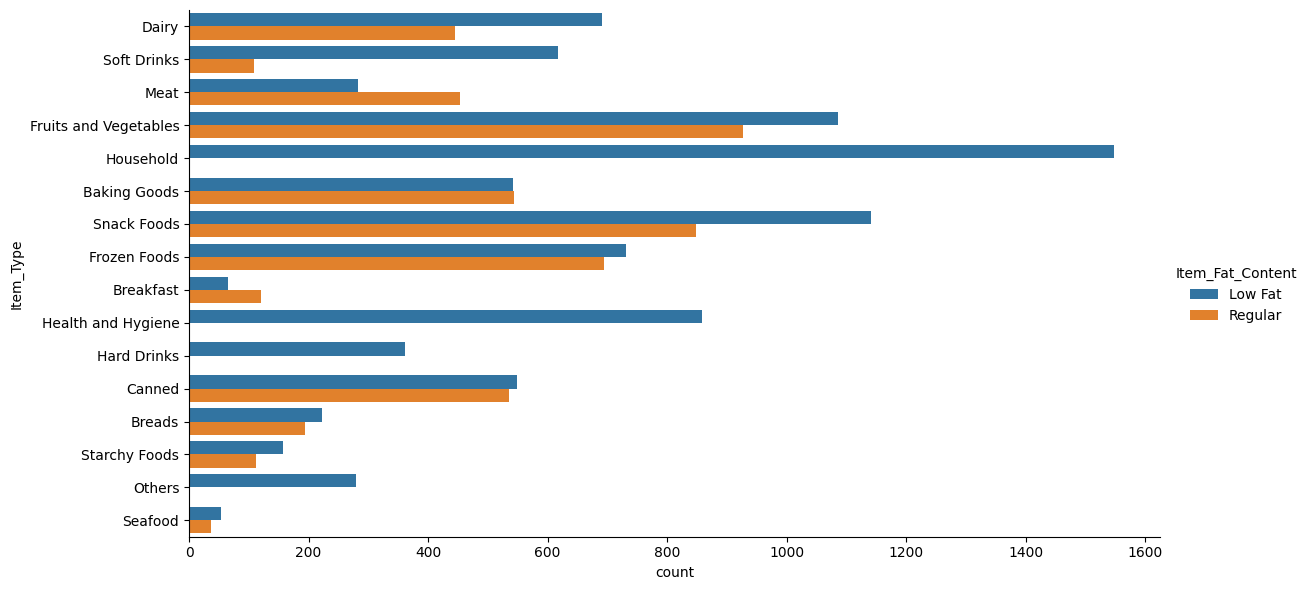

In [159]:
sns.catplot(y="Item_Type", hue="Item_Fat_Content", kind="count", data=data, height=6, aspect=2)
plt.show()

Existen productos con categoría "Low Fat" que no son comestibles o que simplemente no tienen ningún contenido de grasa, para ser consistentes se asigna una nueva categoría NA (No aplica) para los tipos de productos Household, Health and Hygiene, Hard Drinks, Soft Drinks, Fruits and Vegetables:

## Features Engineering

#### FEATURES ENGINEERING: asignación de nueva categorías para 'Item_Fat_Content'

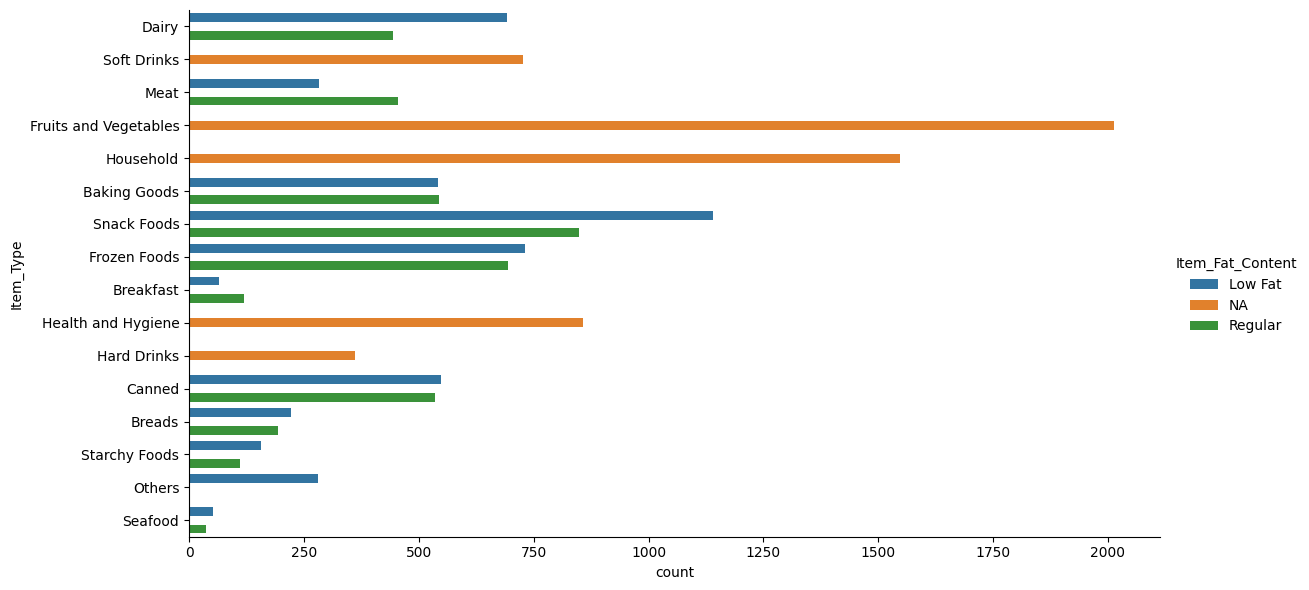

In [ ]:
# FEATURES ENGINEERING: asignación de nueva categorías para 'Item_Fat_Content'

data.loc[data['Item_Type'] == 'Household', 'Item_Fat_Content'] = 'NA'
data.loc[data['Item_Type'] == 'Health and Hygiene', 'Item_Fat_Content'] = 'NA'
data.loc[data['Item_Type'] == 'Hard Drinks', 'Item_Fat_Content'] = 'NA'
data.loc[data['Item_Type'] == 'Soft Drinks', 'Item_Fat_Content'] = 'NA'
data.loc[data['Item_Type'] == 'Fruits and Vegetables', 'Item_Fat_Content'] = 'NA'

sns.catplot(y="Item_Type", hue="Item_Fat_Content", kind="count", data=data, height=6, aspect=2)
plt.show()

Analicemos los niveles de ventas por contenido de grasa de los productos:

In [ ]:
# H0: las medias son significativamente iguales entre los grupos
stats.kruskal(list(data.dropna().loc[data['Item_Fat_Content']== 'Low Fat', 'Item_Outlet_Sales']), list(data.dropna().loc[data['Item_Fat_Content']== 'Regular', 'Item_Outlet_Sales']),
             list(data.dropna().loc[data['Item_Fat_Content']== 'NA', 'Item_Outlet_Sales']))  

No se evidencia diferencias significativas en los niveles de ventas entre las 3 categorias de la característica Item_Fat_Content. Veamos un gráfico de ello:

In [ ]:
sns.violinplot(x="Item_Fat_Content", y='Item_Outlet_Sales', kind="bar", data=data)
plt.show()

In [ ]:
sns.catplot(x="Item_Type", y='Item_Outlet_Sales', hue="Item_Fat_Content", kind="bar", data=data, height=5, aspect=4)
plt.show()

De forma similar lo vemos en el gráfico por tipo de producto, intentemos reagrupar dichas categoría para buscar una relación significativa con el nivel de ventas.

Veamos una clasificación por usos:
- Consultando las categorias de idenificación de los tipos de productos

In [ ]:
print(list(data[data['Item_Type'] == 'Others']['Item_Identifier'].unique()))

In [ ]:
print(list(data[data['Item_Type'] == 'Health and Hygiene']['Item_Identifier'].unique()))

In [ ]:
print(list(data[data['Item_Type'] == 'Household']['Item_Identifier'].unique()))

En general se observa: FD = ALIMENTOS - NC = HOGAR, SALUD E HIG, OTROS - DR = BEBIDAS, 

#### FEATURES ENGINEERING: creando categorías para 'Item_Type'

In [ ]:
# FEATURES ENGINEERING: creando categorías para 'Item_Type'
data['Item_Type'] = data['Item_Type'].replace({'Others': 'Non perishable', 'Health and Hygiene': 'Non perishable', 'Household': 'Non perishable',
 'Seafood': 'Meats', 'Meat': 'Meats',
 'Baking Goods': 'Processed Foods', 'Frozen Foods': 'Processed Foods', 'Canned': 'Processed Foods', 'Snack Foods': 'Processed Foods',
 'Breads': 'Starchy Foods', 'Breakfast': 'Starchy Foods',
 'Soft Drinks': 'Drinks', 'Hard Drinks': 'Drinks', 'Dairy': 'Drinks'})

# FEATURES ENGINEERING: asignación de nueva categorías para 'Item_Fat_Content'
data.loc[data['Item_Type'] == 'Non perishable', 'Item_Fat_Content'] = 'NA'

Visualicemos de nuevo esta recategorización en un gráfico:

In [ ]:
#plt.figure(figsize=(12,4))
#sns.violinplot(x="Item_Type", y='Item_Outlet_Sales', hue="Item_Fat_Content", data=data)
#plt.show()

plt.figure(figsize=(12,4))
sns.violinplot(x='Item_Type', y="Item_Outlet_Sales", data=data)
plt.show()

In [ ]:
data['Item_Type'].unique()

In [ ]:
# H0: las medias son significativamente iguales entre los grupos
stats.kruskal(list(data.dropna().loc[data['Item_Type']== 'Drinks', 'Item_Outlet_Sales']), list(data.dropna().loc[data['Item_Type']== 'Meats', 'Item_Outlet_Sales']),
             list(data.dropna().loc[data['Item_Type']== 'Fruits and Vegetables', 'Item_Outlet_Sales']), 
             list(data.dropna().loc[data['Item_Type']== 'Non perishable', 'Item_Outlet_Sales']),
             list(data.dropna().loc[data['Item_Type']== 'Fruits and Vegetables', 'Item_Outlet_Sales']),
             list(data.dropna().loc[data['Item_Type']== 'Processed Foods', 'Item_Outlet_Sales']),
             list(data.dropna().loc[data['Item_Type']== 'Starchy Foods', 'Item_Outlet_Sales']))  

No se evidencia diferencias en los niveles de ventas entre las diferentes categorias de tipo de productos (reagrupados).

### Análisis Bi-variado:
Variables Continuas vs Continuas

In [ ]:
numerics_var = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
sns.pairplot(data.dropna(), x_vars=numerics_var, y_vars=numerics_var, kind='scatter', diag_kind='kde' )
#plt.savefig('hist_scatter')
plt.show()

No se observa alguna relación significativa entre las variables, lo que señala la necesidad de preprocesar los datos y realizar algunas transformaciones.

Veamos las correlaciones entre estas variables.

In [ ]:
data[numerics_var].corr()

- La característica con correlación más alta es Item_MRP (r=0.57), corresponde a una correlación de nivel moderado.
- El Target guarda una relación casi nula con los pesos de los productos, mientras que con el grado de visibilidad del producto se observa una correlación baja negativa (r=-0.13). Esta última correlación no parece tener sentido, lo que sugiere que estos valores puede que no esten bien registrados.
- Un aspecto positivo es que la correlación entre las variables independientes es baja, lo que indica que no existe autocorrelación entre estas vraiables.

#### FEATURES ENGINEERING: Codificando los niveles de precios de los productos

In [ ]:
print(pd.qcut(data['Item_MRP'], 4,).unique())
data['Item_MRP'] = pd.qcut(data['Item_MRP'], 4, labels = [1, 2, 3, 4])

### Codificación de variables ordinales:
Esta vez no se considera tomar las características: 'Item_Type' y 'Item_Fat_Content'

Se utiliza una copia de data para separar los valores codificados en un dataframe distinto.

In [ ]:
dataframe = data.drop(columns=['Item_Type', 'Item_Fat_Content']).copy()
dataframe.head()

Se decide realizar una codificación manual y no con algún método automático, para guardar el orden de los valores.  

Las variables ordinales son: ['Outlet_Size', 'Outlet_Location_Type']

In [ ]:
serie_var = dataframe['Outlet_Size'].unique()
serie_var.sort()
print('Outlet_Size', ':', serie_var)

serie_var = dataframe['Outlet_Location_Type'].unique()
serie_var.sort()
print('Outlet_Location_Type', ':', serie_var)

#### FEATURES ENGINEERING: Codificación de variables ordinales

In [ ]:
# Codificación de variables ordinales
dataframe['Outlet_Size'] = dataframe['Outlet_Size'].replace({'High': 2, 'Medium': 1, 'Small': 0})
dataframe['Outlet_Location_Type'] = dataframe['Outlet_Location_Type'].replace({'Tier 1': 2, 'Tier 2': 1, 'Tier 3': 0}) # Estas categorias se ordenaron asumiendo la categoria 2 como más lejos
dataframe.head()

#### FEATURES ENGINEERING: Codificación de variables nominales

In [ ]:
dataframe = pd.get_dummies(dataframe, columns=['Outlet_Type'])
dataframe.head()

In [ ]:
print(dataframe.info())

Revisamos los valores de correlación:

In [ ]:
mask = np.zeros_like(dataframe.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,12))
sns.heatmap(dataframe.corr(), mask=mask, vmax=.3, center=0, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .6})
plt.show()

- El coeficiente de correlación entre las variables independientes es entre bajo y medio, lo que indica que no existe autocorrelación fuerte entre estas variables.

### Preparando data de entrenamiento y de test

In [ ]:
# Eliminación de variables que no contribuyen a la predicción por ser muy específicas
dataset = dataframe.drop(columns=['Item_Identifier', 'Outlet_Identifier'])

# División del dataset de train y test
df_train = dataset.loc[data['Set'] == 'train']
df_test = dataset.loc[data['Set'] == 'test']

# Eliminando columnas sin datos
df_train.drop(['Set'], axis=1, inplace=True)
df_test.drop(['Item_Outlet_Sales','Set'], axis=1, inplace=True)

# Guardando los datasets
df_train.to_csv("train_final.csv")
df_test.to_csv("test_final.csv")

In [ ]:
df_train.head()

In [ ]:
df_test.head()

#### ENTRENAMIENTO

In [ ]:
# Importando librerías para el modelo
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression

seed = 28
model = LinearRegression()

# División de dataset de entrenaimento y validación
X = df_train.drop(columns='Item_Outlet_Sales') #[['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type']] # .drop(columns='Item_Outlet_Sales')
x_train, x_val, y_train, y_val = train_test_split(X, df_train['Item_Outlet_Sales'], test_size = 0.3, random_state=seed)

# Entrenamiento del modelo
model.fit(x_train,y_train)

# Predicción del modelo ajustado para el conjunto de validación
pred = model.predict(x_val)

# Cálculo de los errores cuadráticos medios y Coeficiente de Determinación (R^2)
mse_train = metrics.mean_squared_error(y_train, model.predict(x_train))
R2_train = model.score(x_train, y_train)
print('Métricas del Modelo:')
print('ENTRENAMIENTO: RMSE: {:.2f} - R2: {:.4f}'.format(mse_train**0.5, R2_train))

mse_val = metrics.mean_squared_error(y_val, pred)
R2_val = model.score(x_val, y_val)
print('VALIDACIÓN: RMSE: {:.2f} - R2: {:.4f}'.format(mse_val**0.5, R2_val))

print('\nCoeficientes del Modelo:')
# Constante del modelo
print('Intersección: {:.2f}'.format(model.intercept_))

# Coeficientes del modelo
coef = pd.DataFrame(x_train.columns, columns=['features'])
coef['Coeficiente Estimados'] = model.coef_
print(coef, '\n')
coef.sort_values(by='Coeficiente Estimados').set_index('features').plot(kind='bar', title='Importancia de las variables', figsize=(12, 6))

plt.show()

## Principales variables utilizadas por el modelo:
- Con relación directa: Outlet_Type_Supermarket Type3, Item_MRP
- Con relación inversa: Outlet_Type_Grocery Store, Item_Visibility

### Aplicación del modelo en el dataset de test

In [ ]:
# Predicción del modelo ajustado
data_test = df_test.copy()
data_test['pred_Sales'] = model.predict(data_test)
data_test.to_csv('data_test')
data_test.head()